In [1]:
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import matplotlib as mpl

from importlib import reload

/scratch/v45/dr4292/tmp/.cache/matplotlib is not a writable directory
Matplotlib created a temporary cache directory at /jobfs/132364260.gadi-pbs/matplotlib-8cwl4ezz because there was an issue with the default path (/scratch/v45/dr4292/tmp/.cache/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [90]:
import os, sys

# My imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))


import constants
import toe_constants as toe_const
import time_of_emergence_calc as toe
import time_of_emergence_data_analysis as toe_data_an
toe_calc = toe
import utils

logger = utils.get_notebook_logger()

In [3]:
# client.close()
# from dask.distributed import Client
# client = Client(threads_per_worker=1, n_workers=20)
# client

<h1 style='color:cyan'> Opening Data </h1>

In [4]:
def open_files_datatree(fname_dict, tree_name: str, **kwargs):
    """
    Opens multiple NetCDF files and organizes them into a DataTree.

    Parameters:
    - fname_dict (dict): Dictionary where keys are names and values are file paths.
    - tree_name (str): Name for the root of the DataTree.
    - **kwargs: Additional keyword arguments passed to `xr.open_dataset`.

    Returns:
    - xr.DataTree: A DataTree object containing the datasets.
    """
    data_tree_dict = {}
    for name, path in fname_dict.items():
        ds = xr.open_dataset(path, **kwargs)
        ds.attrs['name'] = name
        dt = xr.DataTree(ds, name=name)
        data_tree_dict[name] = dt
        

    tree = xr.DataTree(name=tree_name, children=data_tree_dict)
    return tree


In [5]:
# Create a data set for the base period used as the pre-industrial climate 
# base_period = #(1959, 1989)#(1900, 1950)#(1900, 1931)
base_period = toe_const.YearRange.MODERN_PERIOD
# base_period, base_period.start, base_period.end
base_period_string = str(base_period.value).replace(', ', '_')
base_period_string, base_period

('(1959_1989)', <YearRange.MODERN_PERIOD: (1959, 1989)>)

In [163]:
# Get just the files that have the string 
files = os.listdir(constants.TOE_SAVE_DIR)
files = [f for f in files if base_period_string in f]
files = [f for f in files if 'access' not in f]

In [164]:
os.listdir(os.path.join(constants.TOE_SAVE_DIR, files[0]))

['data.zarr', 'toe_metrics.zarr', 'data_availability_mask.zarr', 'signal.zarr']

In [165]:
class FileNameManager:
    def __init__(self, file_names: list, root_path: str):
        """
        Initialize the FileNameManager with a list of file names and a root path.

        Parameters:
        - file_names (list): List of file name strings.
        - root_path (str): The root directory path.
        """
        self.file_names = file_names
        self.root_path = root_path

    def generate_dict(self, fname: str) -> dict:
        """
        Generate a dictionary mapping a simplified name (from file_names) to full paths.

        Parameters:
        - fname (str): File name to be appended to each directory.

        Returns:
        - dict: Dictionary with simplified names as keys and full file paths as values.
        """
        return {
            f.split('(')[0].rstrip('_ ').strip(): os.path.join(self.root_path, f, fname)
            for f in self.file_names
        }


In [166]:
# files = [f for f in files if 'access_ssp585_r10i1p1f1_pr_QSJUN_(1959_1989' not in f]
# files

In [167]:
base_file_manager = FileNameManager(files, constants.TOE_SAVE_DIR) #+ '/error')

In [168]:
fname_metric_dict = base_file_manager.generate_dict('toe_metrics.zarr')
fname_signal_dict = base_file_manager.generate_dict('signal.zarr')
fname_data_dict = base_file_manager.generate_dict('data.zarr')
fname_data_dict

{'era5_cape': '/g/data/w40/ab2313/time_of_emergence/toe_metrics/era5_cape_(1959_1989)/data.zarr',
 'best_temperature': '/g/data/w40/ab2313/time_of_emergence/toe_metrics/best_temperature_(1959_1989)/data.zarr',
 'era5_t2m': '/g/data/w40/ab2313/time_of_emergence/toe_metrics/era5_t2m_(1959_1989)/data.zarr'}

In [169]:
toe_metric_tree = open_files_datatree(fname_metric_dict, 'data', engine='zarr', use_cftime=True)

In [170]:
data_tree = open_files_datatree(fname_data_dict, 'data', engine='zarr', use_cftime=True)

In [171]:
signal_tree = open_files_datatree(fname_signal_dict, 'signal', engine='zarr', use_cftime=True)

In [172]:
data_availability_tree = open_files_datatree(fname_signal_dict, 'data_availability_mask', 
                                             engine='zarr', use_cftime=True)

In [173]:
list(toe_metric_tree)

['era5_cape', 'best_temperature', 'era5_t2m']

In [174]:
toe_metric_tree

<xarray.DataTree 'data'>
Group: /
├── Group: /era5_cape
│       Dimensions:          (time: 46, lat: 721, lon: 1440)
│       Coordinates:
│         * lat              (lat) float32 3kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
│         * lon              (lon) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
│         * time             (time) object 368B 1969-12-31 00:00:00 ... 2014-12-31 00...
│       Data variables:
│           frac             (time, lat, lon) float64 382MB ...
│           hd               (time, lat, lon) float64 382MB ...
│           ks               (time, lat, lon) float64 382MB ...
│           perkins          (time, lat, lon) float64 382MB ...
│           sn_hawkins_base  (lat, lon, time) float64 382MB ...
│           sn_hawkins_full  (lat, lon, time) float64 382MB ...
│           sn_lowess_base   (lat, lon, time) float64 382MB ...
│           sn_lowess_full   (lat, lon, time) float64 382MB ...
│       Attributes:
│           long_name:  Kolmogorov-Smirnov
│           name:       era5_cape
├── Group: /best_temperature
│       Dimensions:          (time: 46, lat: 180, lon: 360)
│       Coordinates:
│         * lat              (lat) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
│         * lon              (lon) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
│         * time             (time) object 368B 1969-12-31 00:00:00 ... 2014-12-31 00...
│       Data variables:
│           frac             (time, lat, lon) float64 24MB ...
│           hd               (time, lat, lon) float64 24MB ...
│           ks               (time, lat, lon) float64 24MB ...
│           perkins          (time, lat, lon) float64 24MB ...
│           sn_hawkins_base  (lat, lon, time) float64 24MB ...
│           sn_hawkins_full  (lat, lon, time) float64 24MB ...
│           sn_lowess_base   (lat, lon, time) float64 24MB ...
│           sn_lowess_full   (lat, lon, time) float64 24MB ...
│       Attributes:
│           long_name:  Kolmogorov-Smirnov
│           name:       best_temperature
└── Group: /era5_t2m
        Dimensions:          (time: 46, lat: 721, lon: 1440)
        Coordinates:
          * lat              (lat) float32 3kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
          * lon              (lon) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
          * time             (time) object 368B 1969-12-31 00:00:00 ... 2014-12-31 00...
        Data variables:
            frac             (time, lat, lon) float64 382MB ...
            hd               (time, lat, lon) float64 382MB ...
            ks               (time, lat, lon) float64 382MB ...
            perkins          (time, lat, lon) float64 382MB ...
            sn_hawkins_base  (lat, lon, time) float64 382MB ...
            sn_hawkins_full  (lat, lon, time) float64 382MB ...
            sn_lowess_base   (lat, lon, time) float64 382MB ...
            sn_lowess_full   (lat, lon, time) float64 382MB ...
        Attributes:
            long_name:  Kolmogorov-Smirnov
            name:       era5_t2m

<h1 style='color:cyan'> ToE Calculation </h1>

In [175]:
def get_test_threshold(test: str) -> float:
    if test in toe_const.PVALUE_TESTS:
        return toe_const.PVALUE_THESHOLD1
    elif test in toe_const.OVERLAP_TESTS:
        return toe_const.OVERLAP_THRESHOLD
    elif 'sn' in test:
        return toe_const.SN_THRESHOLD1
    else:
        # Raise an error for unknown tests
        raise ValueError(f"Unknown test '{test}'. Please check the test name or add it"
                         "to the appropriate category.")

# Test that this function works for all tests
for test in list(toe_metric_tree.best_temperature): threshold = get_test_threshold(test); print(test, threshold)
    

frac 62
hd 62
ks 0.01
perkins 62
sn_hawkins_base 1
sn_hawkins_full 1
sn_lowess_base 1
sn_lowess_full 1


In [176]:
def get_non_emergence_multi_metrics(toe_metrics_ds, logginglevel='ERROR'):
    """
    Determine the locations where specific tests do not emerge based on given thresholds.

    Parameters:
    ----------
    toe_metrics_ds : xarray.Dataset
        An xarray Dataset containing time series metrics for multiple tests.
        Each variable in the dataset represents a test, and the final time 
        step (time=-1) is used for comparison against the test's threshold.
    
    logginglevel : str, optional
        The logging level to use during execution. Default is 'ERROR'.
        Possible values: 'DEBUG', 'INFO', 'WARNING', 'ERROR', 'CRITICAL'.

    Returns:
    -------
    xarray.Dataset
        A merged dataset where each variable indicates the non-emergence
        condition for the corresponding test in `toe_metrics_ds`. The variables
        are named based on their corresponding test names.

    Notes:
    -----
    - For signal-to-noise ratio (SNR)-related tests (e.g., test names containing "sn"), 
      the non-emergence condition is defined as `np.abs(value) <= threshold`.
    - For all other tests, the non-emergence condition is defined as `value >= threshold`.
    """

    # Adjust the logging level as per the specified parameter
    utils.change_logginglevel(logginglevel)
    
    to_concat = []  # List to store DataArrays for each test's non-emergence condition

    for test in list(toe_metrics_ds):
        # Retrieve the threshold for the current test
        threshold = get_test_threshold(test)
        logger.info(f'{test} - {threshold}')  # Log the test name and its threshold

        # Determine the appropriate comparison function based on the tst type
        # Use np.less_equal for "sn" tests and np.greater_equal for others
        comp_func = np.less_equal if (('sn' in test) or ('hd' in test)) else np.greater_equal

        # Apply the comparison function to determine non-emergence locations
        # For "sn" tests: np.abs(value) <= threshold
        # For others: value >= threshold
        does_not_emerge_da = comp_func(np.abs(toe_metrics_ds[test].isel(time=-1)), threshold)

        # Append the resulting DataArray to the list for later merging
        to_concat.append(does_not_emerge_da)

    # Merge all individual non-emergence DataArrays into a single Dataset
    does_not_emerge_ds = xr.merge(to_concat)

    return does_not_emerge_ds

In [177]:
def get_permanent_exceedance_multi_metrics(toe_metrics_ds, logginglevel='ERROR'):
    """
    Determine the year of permanent exceedance for multiple tests in the dataset.

    Parameters:
    ----------
    toe_metrics_ds : xarray.Dataset
        An xarray Dataset containing time series metrics for multiple tests.
    
    simulation_max : float
        The maximum simulation year. If a test exceeds this year, it is considered not emerged.

    Returns:
    -------
    xarray.Dataset
        A merged dataset containing the year of permanent exceedance for all tests.
    """
    utils.change_logginglevel(logginglevel)

    logger.debug(toe_metrics_ds)
        
    exceedance_list = []

    for test in toe_metrics_ds:
        # Retrieve the threshold dynamically
        threshold = get_test_threshold(test)

        # Determine the comparison function
        comp_func = np.greater_equal if (('sn' in test) or ('hd' in test)) else np.less
        logger.info(f'{test=} - {threshold=} - {comp_func}')

        # Apply absolute value for 'sn'-related tests
        data = np.abs(toe_metrics_ds[test]) if 'sn' in test else toe_metrics_ds[test]

        # Calculate permanent exceedance
        exceedance_da = toe.get_permanent_exceedance(data, threshold=threshold, comparison_func=comp_func)

        exceedance_list.append(exceedance_da)

    # Merge all exceedance results
    toe_ds = xr.merge(exceedance_list)

    # Apply the simulation max threshold
    # toe_ds = xr.where(toe_ds < simulation_max, toe_ds, np.nan)
    return toe_ds


In [178]:
def check_for_null(ds):
    return not ds.dims and not ds.data_vars

In [179]:
def sign_final_time(toe_metrics_ds): 
    if check_for_null(toe_metrics_ds): return
    da = xr.where(toe_metrics_ds.sn_lowess_full.isel(time=-1) > 0, 1, -1)
    da.name = 'sign'
    ds = da.to_dataset()
    return ds

In [180]:
list(toe_metric_tree)

['era5_cape', 'best_temperature', 'era5_t2m']

In [181]:
sign_tf_tree = toe_metric_tree.map_over_datasets(sign_final_time)

In [182]:
toe_tree = toe_metric_tree.map_over_datasets(get_permanent_exceedance_multi_metrics, 'ERROR')

In [183]:
does_not_emerge_tree = toe_metric_tree.map_over_datasets(get_non_emergence_multi_metrics)

In [184]:
toe_tree

<xarray.DataTree 'data'>
Group: /
├── Group: /era5_cape
│       Dimensions:          (lat: 721, lon: 1440)
│       Coordinates:
│         * lat              (lat) float32 3kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
│         * lon              (lon) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
│       Data variables:
│           frac             (lat, lon) float64 8MB nan nan nan nan ... nan nan nan nan
│           hd               (lat, lon) float64 8MB nan nan nan nan ... nan nan nan nan
│           ks               (lat, lon) float64 8MB nan nan nan ... 1.994e+03 1.994e+03
│           perkins          (lat, lon) float64 8MB nan nan nan nan ... nan nan nan nan
│           sn_hawkins_base  (lat, lon) float64 8MB nan nan nan nan ... nan nan nan nan
│           sn_hawkins_full  (lat, lon) float64 8MB nan nan nan nan ... nan nan nan nan
│           sn_lowess_base   (lat, lon) float64 8MB nan nan nan nan ... nan nan nan nan
│           sn_lowess_full   (lat, lon) float64 8MB nan nan nan nan ... nan nan nan nan
│       Attributes:
│           bw_method:  0.2
│           long_name:  Fractional Geometric Area
├── Group: /best_temperature
│       Dimensions:          (lat: 180, lon: 360)
│       Coordinates:
│         * lat              (lat) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
│         * lon              (lon) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
│       Data variables:
│           frac             (lat, lon) float64 518kB 2.004e+03 2.004e+03 ... 1.998e+03
│           hd               (lat, lon) float64 518kB 2.011e+03 2.011e+03 ... 2.003e+03
│           ks               (lat, lon) float64 518kB 2.004e+03 2.004e+03 ... 1.997e+03
│           perkins          (lat, lon) float64 518kB 2.004e+03 2.004e+03 ... 1.998e+03
│           sn_hawkins_base  (lat, lon) float64 518kB 2.003e+03 2.003e+03 ... 1.989e+03
│           sn_hawkins_full  (lat, lon) float64 518kB 2.012e+03 2.012e+03 ... 1.99e+03
│           sn_lowess_base   (lat, lon) float64 518kB 1.999e+03 1.999e+03 ... 1.994e+03
│           sn_lowess_full   (lat, lon) float64 518kB 2.006e+03 2.006e+03 ... 1.995e+03
│       Attributes:
│           bw_method:  0.2
│           long_name:  Fractional Geometric Area
└── Group: /era5_t2m
        Dimensions:          (lat: 721, lon: 1440)
        Coordinates:
          * lat              (lat) float32 3kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
          * lon              (lon) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
        Data variables:
            frac             (lat, lon) float64 8MB nan nan nan ... 1.987e+03 1.987e+03
            hd               (lat, lon) float64 8MB nan nan nan ... 2.005e+03 2.005e+03
            ks               (lat, lon) float64 8MB nan nan nan ... 1.988e+03 1.988e+03
            perkins          (lat, lon) float64 8MB nan nan nan ... 1.984e+03 1.984e+03
            sn_hawkins_base  (lat, lon) float64 8MB nan nan nan ... 1.991e+03 1.991e+03
            sn_hawkins_full  (lat, lon) float64 8MB nan nan nan ... 1.991e+03 1.991e+03
            sn_lowess_base   (lat, lon) float64 8MB nan nan nan ... 1.987e+03 1.987e+03
            sn_lowess_full   (lat, lon) float64 8MB nan nan nan ... 1.988e+03 1.988e+03
        Attributes:
            bw_method:  0.2
            long_name:  Fractional Geometric Area

In [185]:
list(toe_tree)

['era5_cape', 'best_temperature', 'era5_t2m']

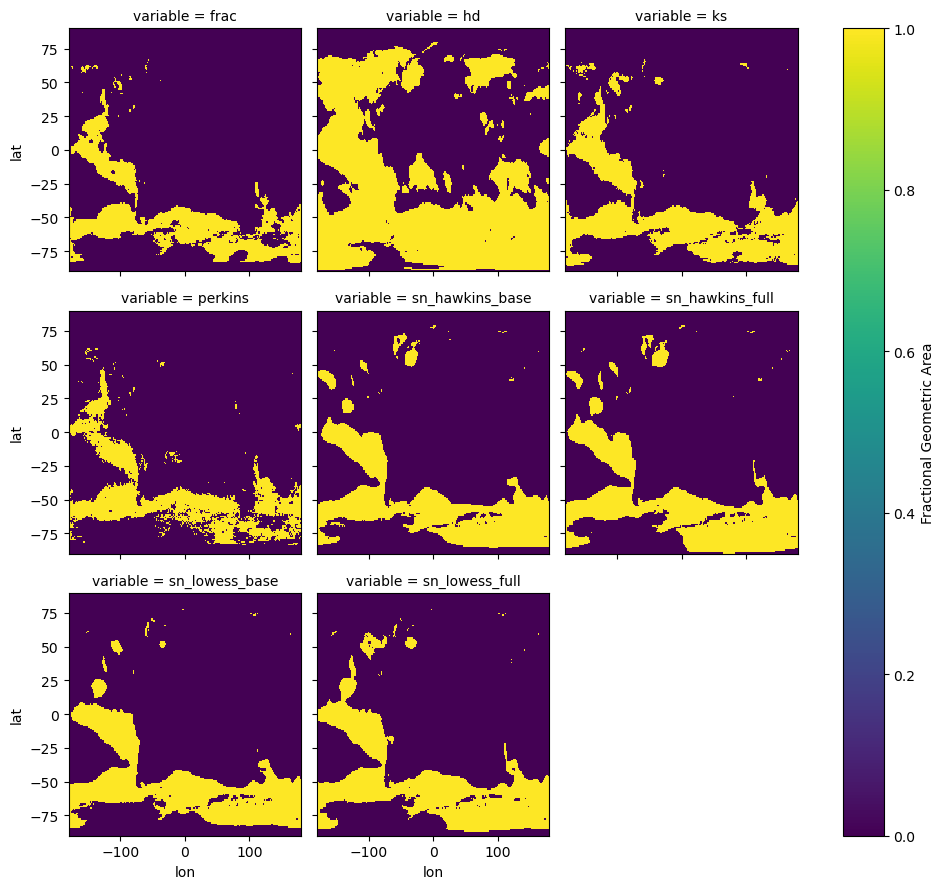

In [186]:
does_not_emerge_tree.best_temperature.to_dataset().to_array().plot(col='variable', col_wrap=3)

In [187]:
list(sign_tf_tree)

['era5_cape', 'best_temperature', 'era5_t2m']

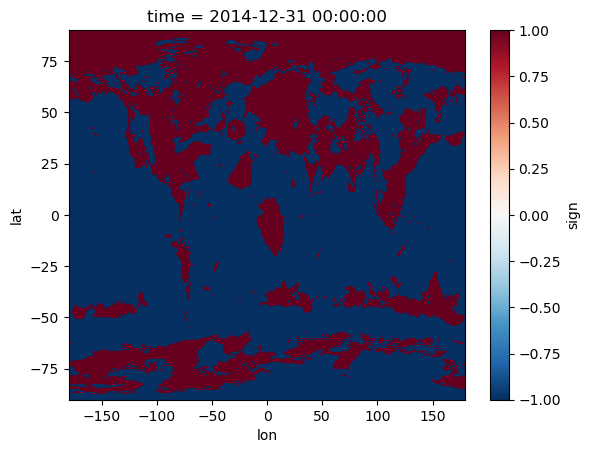

In [188]:
sign_tf_tree['era5_cape'].sign.plot()

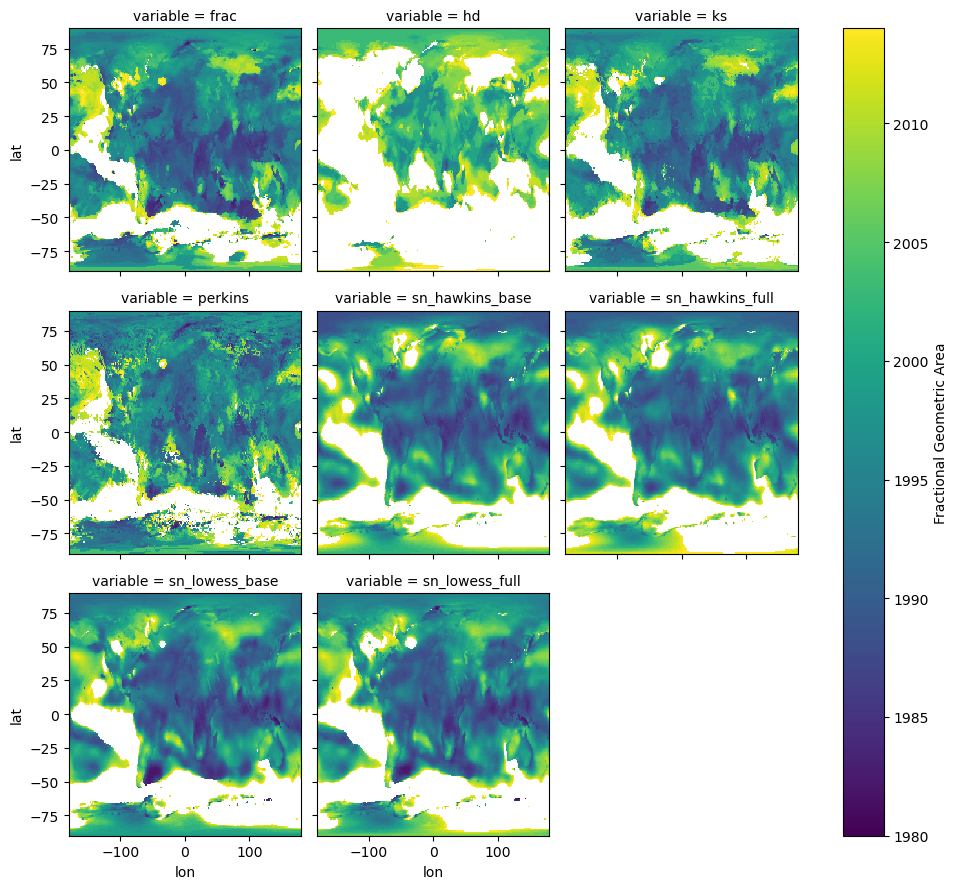

In [189]:
toe_tree.best_temperature.to_dataset().to_array().plot(col='variable', col_wrap=3)

In [210]:
def percent_emerged(toe_metric_ds, toe_ds):
    # Check for null input
    if check_for_null(toe_metric_ds): 
        return

    # print(toe_metric_ds, toe_ds, sep='\n---\n')

    # Ensure proper handling of xarray objects
    if not isinstance(toe_metric_ds, (xr.Dataset, xr.DataArray)):
        raise TypeError(f"Expected xarray.Dataset or xarray.DataArray, got {type(toe_metric_ds)}")
    
    # Ensure time dimension is valid
    if 'time' not in toe_metric_ds.dims or not hasattr(toe_metric_ds.time, 'dt'):
        raise ValueError("The 'time' dimension is missing or not a datetime array in toe_metric_ds.")

    # Apply binary emergence calculation
    binary_emergence_ds = xr.apply_ufunc(
        toe_data_an.calculate_returned_binary_ds,
        toe_metric_ds,
        toe_ds,
        toe_metric_ds.time.dt.year.values,
        input_core_dims=[['time'], [], ['time']],
        output_core_dims=[['time']],
        vectorize=True,
        dask='parallelized'
    )
    
    # Convert values to binary (1 or 0)
    binary_emergence_ds = xr.where(binary_emergence_ds == 1, 1, 0)
    
    # Compute weights and percentage emergence
    only_1s_ds = xr.ones_like(binary_emergence_ds.isel(time=0))
    weights = toe_data_an.compute_weights(binary_emergence_ds)
    
    emergence_time_series_ds = toe_data_an.percentage_lat_lons(
        binary_emergence_ds, only_1s_ds, weights
    )
    
    return emergence_time_series_ds


In [211]:
emergence_time_series_tree = xr.map_over_datasets(percent_emerged, toe_metric_tree, toe_tree)

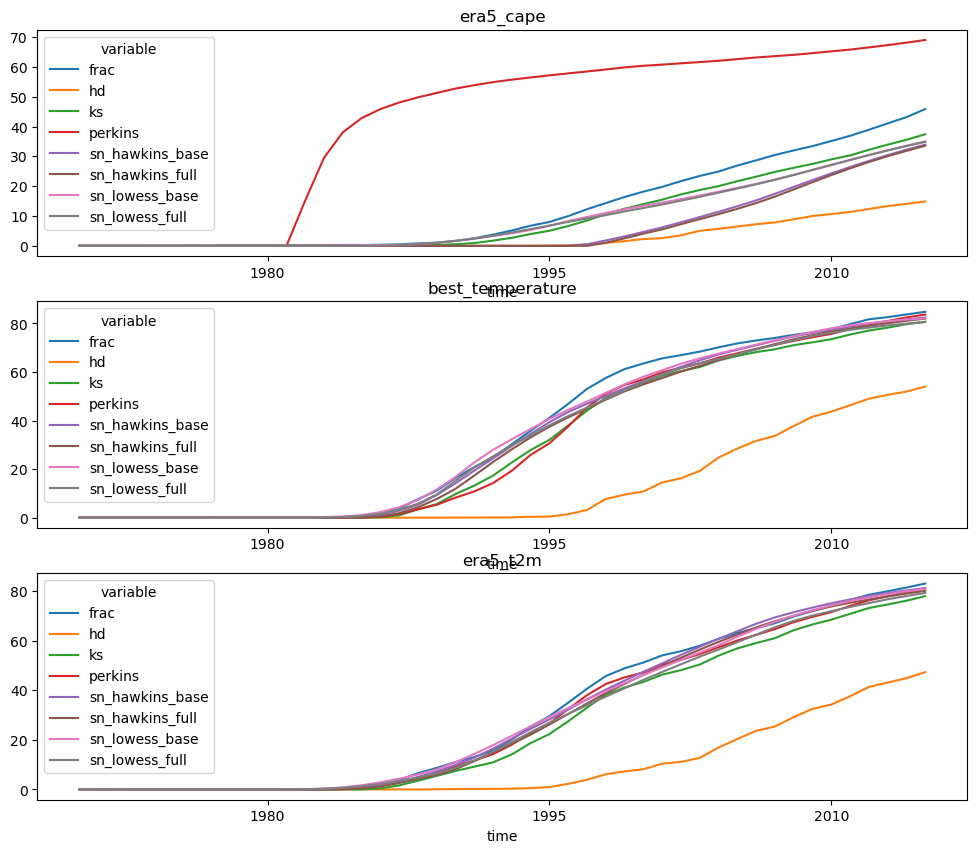

In [212]:
fig = plt.figure(figsize=(12, 10))

n_rows = len(emergence_time_series_tree)

for num, var in enumerate(emergence_time_series_tree):
    
    da = emergence_time_series_tree[var].to_dataset().to_array()

    ax = fig.add_subplot(n_rows, 1, num+1)
    da.plot(ax=ax, hue='variable')
    ax.set_title(var)

<h1 style='color:cyan'> Plots</h1>

<h2 style='color:yellow'> Set-up </h2>

In [213]:
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors

In [214]:
# Create a custom colormap with two colors: gray and transparent
colors = [(0, 0, 0, 0), (0.5, 0.5, 0.5, 1)]  # (R, G, B, Alpha)
cmap_binary = mcolors.LinearSegmentedColormap.from_list("binary_no_color", colors)

In [217]:
from dataclasses import dataclass

@dataclass
class PlotLevels:
    start: int
    stop: int
    step: int

    def generate_range(self):
        """Generate a numpy array based on the start, stop, and step."""
        return np.arange(self.start, self.stop, self.step)

In [219]:
LEVEL_TYPES = {
    'historical': PlotLevels(start=1970, stop=2015, step=5),
    'access':PlotLevels(start=1970, stop=2300, step=20)
}

PLOT_LEVELS = {
    item: LEVEL_TYPES['access'] if 'access' in item else LEVEL_TYPES['historical']
    for item in list(toe_tree)
}

PLOT_LEVELS

{'era5_cape': PlotLevels(start=1970, stop=2015, step=5),
 'best_temperature': PlotLevels(start=1970, stop=2015, step=5),
 'era5_t2m': PlotLevels(start=1970, stop=2015, step=5)}

In [220]:
PLOT_LEVELS['best_temperature'].generate_range()

array([1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010])

In [225]:
def create_discrete_colorbar(cmap, levels, cax, label, fontscale=1):
    """
    Create a discrete colorbar with the given colormap and levels.
    
    Args:
        cmap: Colormap to use.
        levels: Discrete levels (boundaries).
        cax: Colorbar axis.
        label: Label for the colorbar.
    """
    norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
    # cbar.set_label(label, fontsize=16)
    cbar.ax.set_title(label, fontsize=12*fontscale, pad=20)
    # Scale y-tick labels' font size
    cbar.ax.tick_params(axis='y', labelsize=10 * fontscale)
    return cbar

<h2 style='color:yellow'> Plot lab </h2>

Text(0, 0.5, 'Warming')

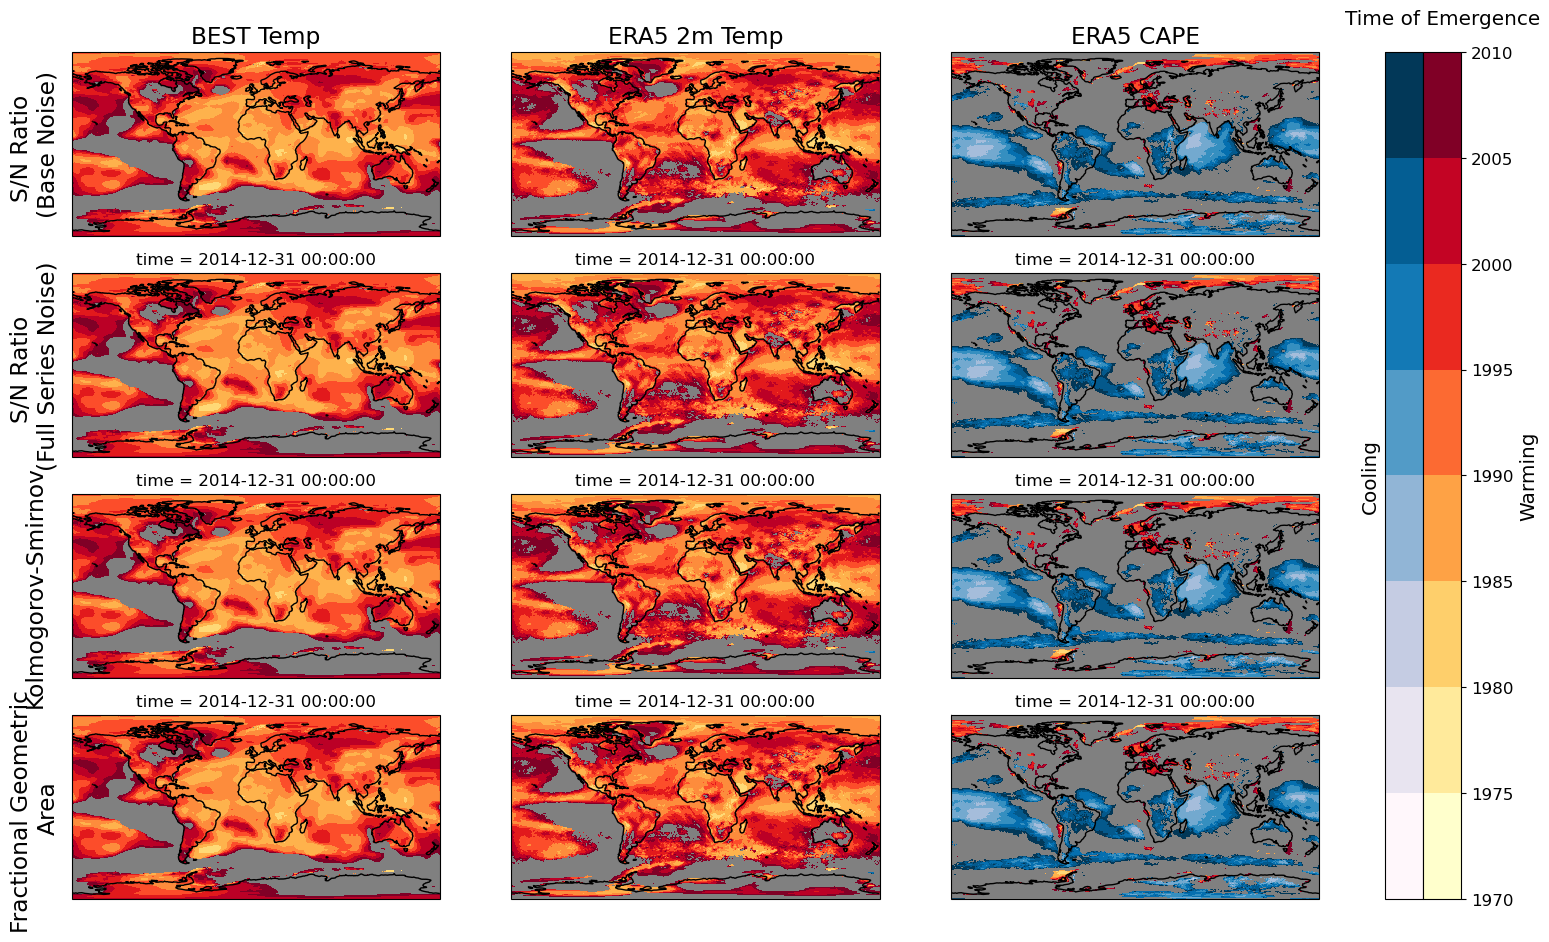

In [242]:
fontscale = 1.2

tests_subset_used = ['sn_lowess_base', 'sn_lowess_full', 'ks', 'frac']#, 'perkins', 'hd']
tests_var_used = ['best_temperature', 'era5_t2m', 'era5_cape']#'access_ssp585_r10i1p1f1_pr_QSDEC']


fig = plt.figure(figsize=(6*len(list(tests_var_used)), 11))
gs  = gridspec.GridSpec(len(tests_subset_used), len(tests_var_used) +1, 
                       width_ratios = [1, 1, 1, 0.2])
cmap1 = plt.cm.PuBu
cmap2 = plt.cm.YlOrRd


axes = np.array([
    [fig.add_subplot(gs[row, col], projection=ccrs.PlateCarree()) for col in [0, 1, 2]]
    for row in range(len(tests_subset_used))
])


for col,variable in enumerate(list(tests_var_used)):
    
    toe_emergence_levels = PLOT_LEVELS[variable].generate_range()

    not_stable_kwargs2 = dict(cmap=cmap_binary, add_colorbar=False)
    toe_plot_kwargs = dict(add_colorbar=False, levels=toe_emergence_levels)

    for row, metric in enumerate(tests_subset_used):

        ax = axes[row, col]
        does_not_emerge_tree[variable].to_dataset()[test].plot(ax=ax, **not_stable_kwargs2)

        toe_ds = toe_tree[variable].to_dataset()[test]
        toe_ds.where(sign_tf_tree[variable].sign == 1).plot(cmap=cmap2, ax=ax, **toe_plot_kwargs)
        toe_ds.where(sign_tf_tree[variable].sign == -1).plot(cmap=cmap1, ax=ax, **toe_plot_kwargs)
        # toe_plot = toe_tree[variable].to_dataset()[test].plot(ax=ax, **toe_plot_kwargs)

        ax.coastlines()

        if col == 0:
            row_label = toe_const.NAME_CONVERSION_DICT.get(metric, metric).replace('(', '\n(')
            if 'LOWESS' in row_label: row_label = row_label.replace('LOWESS, ', '')
            if 'Area' in row_label: row_label = row_label.replace('Area', '\nArea')
            ax.annotate(row_label, xy=(-0.1, 0.5), xycoords = 'axes fraction',
                                 rotation=90, ha='center', va='center', fontsize=14*fontscale)
            
        if row == 0: ax.set_title(toe_const.VARIABLE_CONVERSION_DICT.get(variable, variable), fontsize=14*fontscale)


cax_gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[:, -1], wspace=0)
caxes = [plt.subplot(cax_gs1[:, i]) for i in [0, 1]]

# Create colorbars
cbar1 = create_discrete_colorbar(
    cmap1, PLOT_LEVELS['best_temperature'].generate_range(), caxes[0], '')
cbar2 = create_discrete_colorbar(
    cmap2, PLOT_LEVELS['best_temperature'].generate_range(), caxes[1], 'Time of Emergence',
    fontscale=fontscale)

cbar1.ax.set_yticks([]);


cbar1.ax.set_ylabel('Cooling', fontsize=12*fontscale)
cbar1.ax.yaxis.set_label_position('left')
cbar2.ax.set_ylabel('Warming', fontsize=12*fontscale)


Text(0, 0.5, 'Warming')

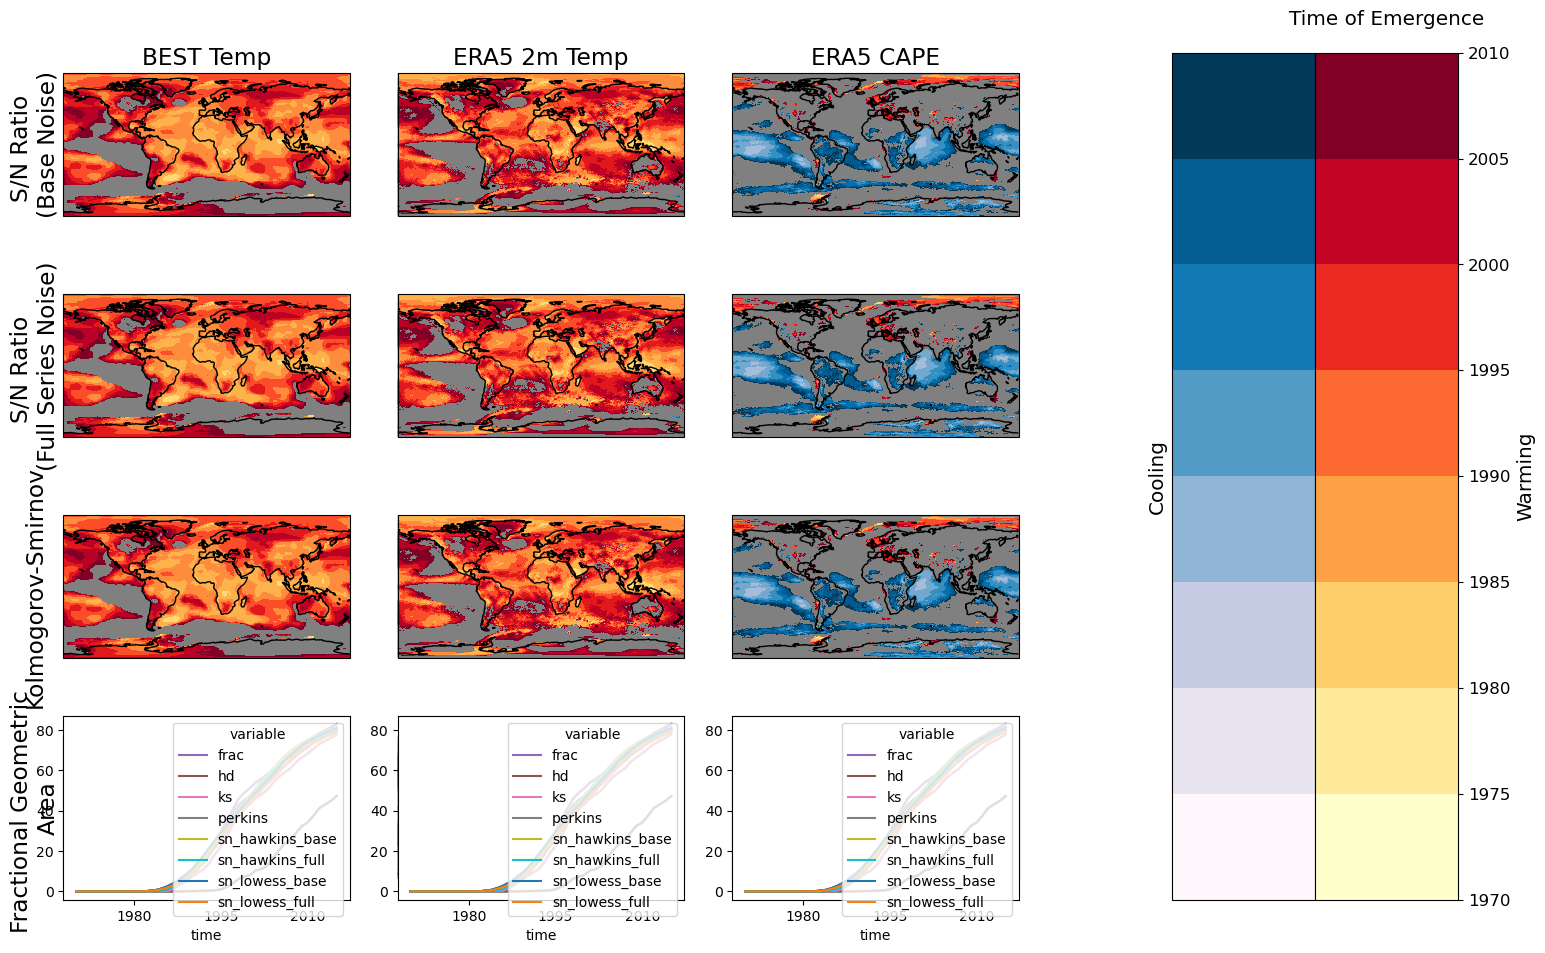

In [248]:
fontscale = 1.2

tests_subset_used = ['sn_lowess_base', 'sn_lowess_full', 'ks', 'frac']#, 'perkins', 'hd']
tests_var_used = ['best_temperature', 'era5_t2m', 'era5_cape']#'access_ssp585_r10i1p1f1_pr_QSDEC']


fig = plt.figure(figsize=(6*len(list(tests_var_used)), 11))
gs  = gridspec.GridSpec(len(tests_subset_used), len(tests_var_used) +1+1, 
                       width_ratios = [1, 1, 1, 0.2])
cmap1 = plt.cm.PuBu
cmap2 = plt.cm.YlOrRd


axes = np.array([
    [fig.add_subplot(gs[row, col], projection=ccrs.PlateCarree()) for col in [0, 1, 2]]
    for row in range(len(tests_subset_used))
])



bottom_axes = [fig.add_subplot(gs[-1, col]) for col in [0, 1, 2]]




for col,variable in enumerate(list(tests_var_used)):
    
    toe_emergence_levels = PLOT_LEVELS[variable].generate_range()

    not_stable_kwargs2 = dict(cmap=cmap_binary, add_colorbar=False)
    toe_plot_kwargs = dict(add_colorbar=False, levels=toe_emergence_levels)

    for row, metric in enumerate(tests_subset_used):

        ax = axes[row, col]
        does_not_emerge_tree[variable].to_dataset()[test].plot(ax=ax, **not_stable_kwargs2)

        toe_ds = toe_tree[variable].to_dataset()[test]
        toe_ds.where(sign_tf_tree[variable].sign == 1).plot(cmap=cmap2, ax=ax, **toe_plot_kwargs)
        toe_ds.where(sign_tf_tree[variable].sign == -1).plot(cmap=cmap1, ax=ax, **toe_plot_kwargs)
        # toe_plot = toe_tree[variable].to_dataset()[test].plot(ax=ax, **toe_plot_kwargs)

        ax.coastlines()

        if col == 0:
            row_label = toe_const.NAME_CONVERSION_DICT.get(metric, metric).replace('(', '\n(')
            if 'LOWESS' in row_label: row_label = row_label.replace('LOWESS, ', '')
            if 'Area' in row_label: row_label = row_label.replace('Area', '\nArea')
            ax.annotate(row_label, xy=(-0.1, 0.5), xycoords = 'axes fraction',
                                 rotation=90, ha='center', va='center', fontsize=14*fontscale)

        title = (toe_const.VARIABLE_CONVERSION_DICT.get(variable, variable) if row==0 else '')
        ax.set_title(title, fontsize=14*fontscale)
            
        ### Time seires

        bax = bottom_axes[col]
        emergence_time_series_tree[var].to_dataset().to_array().plot(ax=bax, hue='variable')


cax_gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[:, -1], wspace=0)
caxes = [plt.subplot(cax_gs1[:, i]) for i in [0, 1]]

# Create colorbars
cbar1 = create_discrete_colorbar(
    cmap1, PLOT_LEVELS['best_temperature'].generate_range(), caxes[0], '')
cbar2 = create_discrete_colorbar(
    cmap2, PLOT_LEVELS['best_temperature'].generate_range(), caxes[1], 'Time of Emergence',
    fontscale=fontscale)

cbar1.ax.set_yticks([]);


cbar1.ax.set_ylabel('Cooling', fontsize=12*fontscale)
cbar1.ax.yaxis.set_label_position('left')
cbar2.ax.set_ylabel('Warming', fontsize=12*fontscale)

In [ ]:
# Create the legend
legend = axes[0].legend(ncol=4, loc='center', bbox_to_anchor=(0.5, 1.45), frameon=True, fontsize=22)
frame = legend.get_frame()
frame.set_color('white')  # Set the legend frame color to white
frame.set_edgecolor('black')  # Set the legend frame edge color to black

In [ ]:
    for test in test_subset:
        color = time_of_emergence_plots.TEST_PLOT_DICT.get(test, {}).get('color', 'red')
        label = toe_const.NAME_CONVERSION_DICT.get(test, '')
        ax.plot(time, region_emergence_ds[test].sel(time=region_emergence_ds.time.dt.year>=1930).values,
                color=color, label=label, linewidth=3)
    ax.grid()
    ax.tick_params(axis='y', labelsize=18)
    ax.tick_params(axis='x', labelsize=22)
    ax.annotate(toe_const.NAMING_MAP.get(region, region), #+ f' (n={number_of_points}, {percent_available:.0f}%)'
                xy=(0.04, 0.8), size=25, xycoords='axes fraction')

    ax.set_yticks(np.arange(0, 120, 20))
    ax.set_ylim(-10, 110)
    ax.set_xlim(*np.take(time, [0, -1]))


    # Ticks every 20 years
    # Getting just the locations where the year is divisible by 10 with no remainder.
    # # Then getting every second one/
    tick_locations = list(filter(lambda t: t % 20 == 0, time))[::2]

# Defunct (Using ACCESS)

In [234]:
tests_subset_used = ['sn_lowess_base', 'sn_lowess_full', 'ks', 'frac']#, 'perkins', 'hd']
tests_var_used = ['best_temperature', 'era5_t2m', 'era5_cape']#'access_ssp585_r10i1p1f1_pr_QSDEC']


fig = plt.figure(figsize=(6*len(list(tests_var_used)), 11))
gs  = gridspec.GridSpec(len(tests_subset_used), len(tests_var_used) +2, 
                       width_ratios = [1, 1, 0.1, 1, 0.1])


cmap1 = plt.cm.YlOrRd
cmap2 = plt.cm.PuBu

axes = np.array([
    [fig.add_subplot(gs[row, col], projection=ccrs.PlateCarree()) for col in [0, 1, 3]]
    for row in range(len(tests_subset_used))
])

caxes = [plt.subplot(gs[:, col]) for col in [2, 4]]

for col,variable in enumerate(list(tests_var_used)):


    
    toe_emergence_levels = PLOT_LEVELS[variable].generate_range()

    not_stable_kwargs2 = dict(cmap=cmap_binary, add_colorbar=False)
    toe_plot_kwargs = dict(add_colorbar=False, levels=toe_emergence_levels)

    for row, metric in enumerate(tests_subset_used):

        ax = axes[row, col]
        does_not_emerge_tree[variable].to_dataset()[test].plot(ax=ax, **not_stable_kwargs2)

        toe_ds = toe_tree[variable].to_dataset()[test]
        toe_ds.where(sign_tf_tree[variable].sign == 1).plot(cmap=cmap1, ax=ax, **toe_plot_kwargs)
        toe_ds.where(sign_tf_tree[variable].sign == -1).plot(cmap=cmap2, ax=ax, **toe_plot_kwargs)
        # toe_plot = toe_tree[variable].to_dataset()[test].plot(ax=ax, **toe_plot_kwargs)

        ax.coastlines()

        if col == 0:
            row_label = toe_const.NAME_CONVERSION_DICT.get(metric, metric).replace('(', '\n(')
            if 'LOWESS' in row_label: row_label = row_label.replace('LOWESS, ', '')
            if 'Area' in row_label: row_label = row_label.replace('Area', '\nArea')
            ax.annotate(row_label, xy=(-0.1, 0.5), xycoords = 'axes fraction',
                                 rotation=90, ha='center', va='center', fontsize=14)
            
        if row == 0: ax.set_title(toe_const.VARIABLE_CONVERSION_DICT.get(variable, variable), fontsize=14)


# caxes = [plt.subplot(gs[:, col]) for col in cax_locs]
cax_gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[:, cax_locs[0]], wspace=0)
caxes1 = [plt.subplot(cax_gs1[:, i]) for i in [0, 1]]

# Create colorbars
cbar1 = create_discrete_colorbar(
    cmap1, PLOT_LEVELS['best_temperature'].generate_range(), caxes1[0], '')
cbar2 = create_discrete_colorbar(
    cmap2, PLOT_LEVELS['best_temperature'].generate_range(), caxes1[1], 'Time of Emergence',
    fontscale=fontscale)

cbar1.ax.set_yticks([]);


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x15475050f2e0> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



Error in callback <function flush_figures at 0x15472c68eb00> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:
list(toe_tree)

In [ ]:
list(toe_tree.best_temperature)

In [ ]:
fontscale = 1.4
tests_subset_used = ['sn_lowess_base', 'ks', 'frac'] # sn_lowess_full#, 'perkins', 'hd']
tests_var_used = [
    'best_temperature', 'era5_t2m', 'era5_cape']
    # 'access_ssp585_r10i1p1f1_pr_QSDEC']
# 'access_ssp585_r10i1p1f1_tasmax'

# cax_locs = [3, 4, 7, 8] # location of cax
cax_locs = [3, 5] # location of cax
num_cols = len(tests_var_used) + len(cax_locs) # num plots + num cax
# width ratio configuration
width_ratios = np.ones(num_cols) 
width_ratios[cax_locs] = 0.2
plot_locs = np.where(width_ratios == 1)[0]

fig = plt.figure(figsize=(6*len(list(tests_var_used)), 11))
gs  = gridspec.GridSpec(len(tests_subset_used), num_cols, width_ratios = width_ratios)

axes = np.array([
    [fig.add_subplot(gs[row, col], projection=ccrs.PlateCarree()) for col in plot_locs]
    for row in range(len(tests_subset_used))
])

# Define the colormap
toe_cmap = plt.cm.RdYlBu

for col,variable in enumerate(list(tests_var_used)):

    toe_emergence_levels = PLOT_LEVELS[variable].generate_range()

    not_stable_kwargs2 = dict(cmap=cmap_binary, add_colorbar=False)
    toe_plot_kwargs = dict(add_colorbar=False, levels=toe_emergence_levels) # cmap=toe_cmap,

    for row, metric in enumerate(tests_subset_used):

        ax = axes[row, col]
        toe_ds = toe_tree[variable].to_dataset()[test]
        toe_ds.where(sign_tf_tree[variable].sign == 1).plot(cmap='YlOrRd', ax=ax, **toe_plot_kwargs)
        toe_ds.where(sign_tf_tree[variable].sign == -1).plot(cmap='PuBu', ax=ax, **toe_plot_kwargs)

        does_not_emerge_tree[variable].to_dataset()[test].plot(ax=ax, **not_stable_kwargs2)

        ax.coastlines()

        if col == 0:
            row_label = toe_const.NAME_CONVERSION_DICT.get(metric, metric).replace('(', '\n(')
            if 'LOWESS' in row_label: row_label = row_label.replace('LOWESS, ', '')
            if 'Area' in row_label: row_label = row_label.replace('Area', '\nArea')
            ax.annotate(row_label, xy=(-0.1, 0.5), xycoords = 'axes fraction',
                                 rotation=90, ha='center', va='center', fontsize=14*fontscale)
            
        if row == 0: 
            ax.set_title(toe_const.VARIABLE_CONVERSION_DICT.get(variable, variable), fontsize=14*fontscale)
        else:
            ax.set_title('')


# caxes = [plt.subplot(gs[:, col]) for col in cax_locs]
cax_gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[:, cax_locs[0]], wspace=0)
caxes1 = [plt.subplot(cax_gs1[:, i]) for i in [0, 1]]

# Create colorbars
cbar1 = create_discrete_colorbar(
    plt.cm.YlOrRd, PLOT_LEVELS['best_temperature'].generate_range(), caxes1[0], '')
cbar2 = create_discrete_colorbar(
    plt.cm.PuBu, PLOT_LEVELS['best_temperature'].generate_range(), caxes1[1], 'Time of Emergence',
    fontscale=fontscale)


cax_gs2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[:, cax_locs[-1]], wspace=0)
caxes2 = [plt.subplot(cax_gs2[:, i]) for i in [0, 1]]

# Create colorbars
cbar3 = create_discrete_colorbar(
    plt.cm.YlOrRd, PLOT_LEVELS['access_ssp585_r10i1p1f1_pr_QSDEC'].generate_range(), caxes2[0], '')

cbar4 = create_discrete_colorbar(
    plt.cm.PuBu, PLOT_LEVELS['access_ssp585_r10i1p1f1_pr_QSDEC'].generate_range(), caxes2[1], 'Time of Emergence', 
    fontscale=fontscale)

cbar3.ax.set_yticks([]);
cbar1.ax.set_yticks([]);

In [ ]:
tests_subset_used = ['sn_lowess_base', 'ks', 'frac'] # sn_lowess_full#, 'perkins', 'hd']
tests_var_used = [
    'best_temperature', 'era5_t2m', 'era5_cape']
    # 'access_ssp585_r10i1p1f1_pr_QSDEC', 'access_ssp585_r10i1p1f1_tas']
# 'access_ssp585_r10i1p1f1_tasmax'

# cax_locs = [3, 4, 7, 8] # location of cax
cax_locs = [3, 6] # location of cax
num_cols = len(tests_var_used) + len(cax_locs) # num plots + num cax
# width ratio configuration
width_ratios = np.ones(num_cols) 
width_ratios[cax_locs] = 0.2
plot_locs = np.where(width_ratios == 1)[0]

fig = plt.figure(figsize=(6*len(list(tests_var_used)), 11))
gs  = gridspec.GridSpec(len(tests_subset_used), num_cols, width_ratios = width_ratios)

axes = np.array([
    [fig.add_subplot(gs[row, col], projection=ccrs.PlateCarree()) for col in plot_locs]
    for row in range(len(tests_subset_used))
])

# Define the colormap
toe_cmap = plt.cm.RdYlBu

for col,variable in enumerate(list(tests_var_used)):

    toe_emergence_levels = PLOT_LEVELS[variable].generate_range()

    not_stable_kwargs2 = dict(cmap=cmap_binary, add_colorbar=False)
    toe_plot_kwargs = dict(add_colorbar=False, levels=toe_emergence_levels) # cmap=toe_cmap,

    for row, metric in enumerate(tests_subset_used):

        ax = axes[row, col]
        toe_ds = toe_tree[variable].to_dataset()[test]
        toe_ds.where(sign_tf_tree[variable].sign == 1).plot(cmap='YlOrRd', ax=ax, **toe_plot_kwargs)
        toe_ds.where(sign_tf_tree[variable].sign == -1).plot(cmap='PuBu', ax=ax, **toe_plot_kwargs)

        does_not_emerge_tree[variable].to_dataset()[test].plot(ax=ax, **not_stable_kwargs2)

        ax.coastlines()

        if col == 0:
            row_label = toe_const.NAME_CONVERSION_DICT.get(metric, metric).replace('(', '\n(')
            if 'LOWESS' in row_label: row_label = row_label.replace('LOWESS, ', '')
            if 'Area' in row_label: row_label = row_label.replace('Area', '\nArea')
            ax.annotate(row_label, xy=(-0.1, 0.5), xycoords = 'axes fraction',
                                 rotation=90, ha='center', va='center', fontsize=14)
            
        if row == 0: 
            ax.set_title(toe_const.VARIABLE_CONVERSION_DICT.get(variable, variable), fontsize=14)
        else:
            ax.set_title('')


# caxes = [plt.subplot(gs[:, col]) for col in cax_locs]
cax_gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[:, cax_locs[0]], wspace=0)
caxes1 = [plt.subplot(cax_gs1[:, i]) for i in [0, 1]]

# Create colorbars
create_discrete_colorbar(
    plt.cm.YlOrRd, PLOT_LEVELS['best_temperature'].generate_range(), caxes1[0], '')
create_discrete_colorbar(
    plt.cm.PuBu, PLOT_LEVELS['best_temperature'].generate_range(), caxes1[1], 'Time of Emergence')


cax_gs2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[:, cax_locs[-1]], wspace=0)
caxes2 = [plt.subplot(cax_gs2[:, i]) for i in [0, 1]]

# Create colorbars
create_discrete_colorbar(
    plt.cm.YlOrRd, PLOT_LEVELS['access_ssp585_r10i1p1f1_pr_QSDEC'].generate_range(), caxes2[0], '')
create_discrete_colorbar(
    plt.cm.PuBu, PLOT_LEVELS['access_ssp585_r10i1p1f1_pr_QSDEC'].generate_range(), caxes2[1], 'Time of Emergence')
